In [9]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.interpolate import interp2d
from matplotlib import cm
plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DeJavu Serif",
    "font.serif": ["Times New Roman"]})


Using the equation set from Cantwell's book, we can write the coupled ODEs for the problem and evaluate them with full non-linearized time dynamics, though the spatial dynamics use the linear interpolation of the radius dataset. We choose a selection of points along the port length at which to track the port radius and local propellant flow, carefully avoiding $x=0$ to dodge the singularity at this location.

In [2]:
## Constants - paraffin and lox
n = 0.62 # power law for radius growth as function of G
m = 0.015 # power law for mdot as function of inverse distance from nozzle
a = 9.27E-5 # m^(2n+m+1) kg^(-n) s^(n-1), multiplier in radius/mdot equations
rhof = 920 # kg/m^3, density of fuel grain

L = 1.143 # m, length of grain
tburn = 100 # end of simulation

Athroat = np.pi*(0.05**2) # 5 cm radius nozzle? guessing here
exp_ratio = 3.2 # again, guessing

def rinitial(x):
    return 0.0508*np.ones_like(x)
    # try:
    #     return 0.0508 + (0.03-0.0508)/(x[-1]-x[0])*(x - x[0]) # m, initial radius as function of distance from port end
    # except:
    #     return 0.0508
    # return 0.0508*np.exp(x/L/6)
#     g = 1.2
#     a = 7
#     b = (g-1)/(L**(1/a))
#     return 0.0508*(b*(x**(1/a)) + 1)
    
def mox(t):
    base_val = 1.7*2.55 # value taken roughly from Cantwell's numerical solution
    return base_val*(1 + 0.5*np.sin(2*np.pi*np.asarray(t)/(0.1*tburn)))
    # return base_val*(1 + 0.5*np.asarray(t)/(tburn)) # linearly decreasing
    # return base_val*np.ones_like(t) # constant mass flux


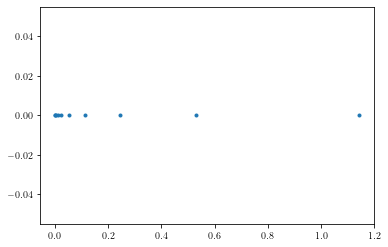

In [3]:
k = 10 # number of grid points
x_start = L/1000 # starting point
logbase = 10000 # base of logspace - higher value means tighter spacing at port start
x = np.logspace(np.log(x_start)/np.log(logbase), np.log(L)/np.log(logbase), num = k, base = logbase) # create logarithmically-spaced points to track curvature near port start
r0 = rinitial(x)
plt.plot(x,np.zeros_like(x),'.')

def rdot_full(t,r):
    mf = np.zeros_like(r)
    for i in range(k):
        if i == 0:
            mflast = 0 # fuel flow at start of port is zero
            dx = x[0]
        else:
            mflast = mf[i-1] # use previous point to do integration
            dx = x[i]-x[i-1]
        mf[i] = mflast + dx*2*np.pi*r[i]*rhof*a/(x[i]**m)*((mox(t)+mflast)/(np.pi*(r[i]**2)))**n # Euler integration
    drdt = a/(x**m)*((mf+mox(t))/(np.pi*(r**2)))**n
    return drdt

In [4]:
# Integrate solution and compute basic output
tspan =  [0, tburn*1.01]
out = solve_ivp(rdot_full, tspan, r0, t_eval = np.linspace(tspan[0], tspan[1], 100), rtol = 1E-6, atol = 1E-6)
tout = out.t
tgrid,xgrid = np.meshgrid(tout,x) # make time and space grid
rout = out.y
moout = np.ones((k,1))*mox([tout])
mfout = np.zeros_like(rout)
for ti in range(len(tout)):
    for i in range(k):
        if i == 0:
            mflast = 0 # first point is just after the port start, so preceding point has mf = 0
            dx = x[0] # first point is just after the port start, so preceding point is x = 0
        else:
            mflast = mfout[i-1,ti]
            dx = x[i]-x[i-1]
        mfout[i,ti] =  mflast + dx*2*np.pi*rout[i,ti]*rhof*a/(x[i]**m)*((moout[i,ti]+mflast)/(np.pi*(rout[i,ti]**2)))**n
mout = moout+mfout    
ofout = moout/mfout

In [5]:
# Import combustion data
combdata = np.loadtxt("CEA/ParaffinLOXCEA.csv",skiprows=1,delimiter=',',usecols=range(5))
OF = combdata[:,0] # OF ratio
Pt = combdata[:,1] # Chamber pressure, Pa
Pmin = Pt[0]
Pmax = Pt[-1]
Tt = combdata[:,2] # Chamber temperature, K
gamma = combdata[:,3] # adiabatic constant
mw = combdata[:,4]/1000 # molecular weight, converted from g/mol to kg/mol

# Create interpolative functions
fTt = interp2d(OF,Pt,Tt)
fgamma = interp2d(OF,Pt,gamma)
fmw = interp2d(OF,Pt,mw)

# Compute thrust assuming perfectly expanded nozzle with known mach number 
def thrust(mfuel,mox,Astar,exp_ratio,fTt=fTt,fgamma=fgamma,fmw=fmw,Pmin=Pmin,Pmax=Pmax,Pamb=101325):
    Ru = 8.31446261815324 # J/K/mol, universal gas constant
    def f(M,g): # mach area function
        return (((g+1)*0.5)**((g+1)*0.5/(g-1))) * M/((1 + 0.5*(g-1)*(M**2))**((g+1)*0.5/(g-1)))
    def invf(Aratio,g):
        return root_scalar(lambda M: (f(M,g)-Aratio),method='brentq', bracket=[1, 10]).root
    def mdot(OF,Pt):
        # interpolate Tt, gamma, mw from combustion data
        Tt = fTt(OF,Pt) # 2D interpolation for chamber temp
        g = fgamma(OF,Pt) # 2D interpolation for chamber gamma
        mw = fmw(OF,Pt) # 2D interpolation for chamber mw
        return g/(((g+1)*0.5)**((g+1)*0.5/(g-1))) * Pt * Astar / np.sqrt(g * Ru/mw * Tt) # isentropic flow of calorically perfect, non-reacting gas
    
    # Given a known OF and total mass flow rate, find the resulting thrust
    OF = mox/mfuel
    mtot = mox+mfuel
    Pt = root_scalar(lambda P: mdot(OF,P)-mtot, x0 = Pmin, x1 = Pmax).root[0]
    Tt = fTt(OF,Pt) # 2D interpolation for chamber temp
    g = fgamma(OF,Pt) # 2D interpolation for chamber gamma
    mw = fmw(OF,Pt) # 2D interpolation for chamber mw
    Me = invf(1/exp_ratio,g) # find exit mach number using expansion ratio
    Pe = Pt * ( 1 + 0.5*(g-1)*(Me**2) )**(-g/(g-1))
    Thrust = mtot*Me*np.sqrt(g * Ru/mw * Tt) + exp_ratio*Astar*(Pe - Pamb)
    return (Thrust, Pt, Tt, Pe, Me)

In [6]:
# Calculate thrust
thrustout = np.zeros_like(tout)
pccout = np.zeros_like(tout)
tccout = np.zeros_like(tout)
peout = np.zeros_like(tout)
meout = np.zeros_like(tout)
for i in range(len(tout)):
    # using mfuel and mox at port end, calc thrust from combustion data
    thrustout[i], pccout[i], tccout[i], peout[i], meout[i] = thrust(mfout[-1,i],moout[-1,i],Athroat,exp_ratio)

Text(0.5, 1.0, 'Thrust')

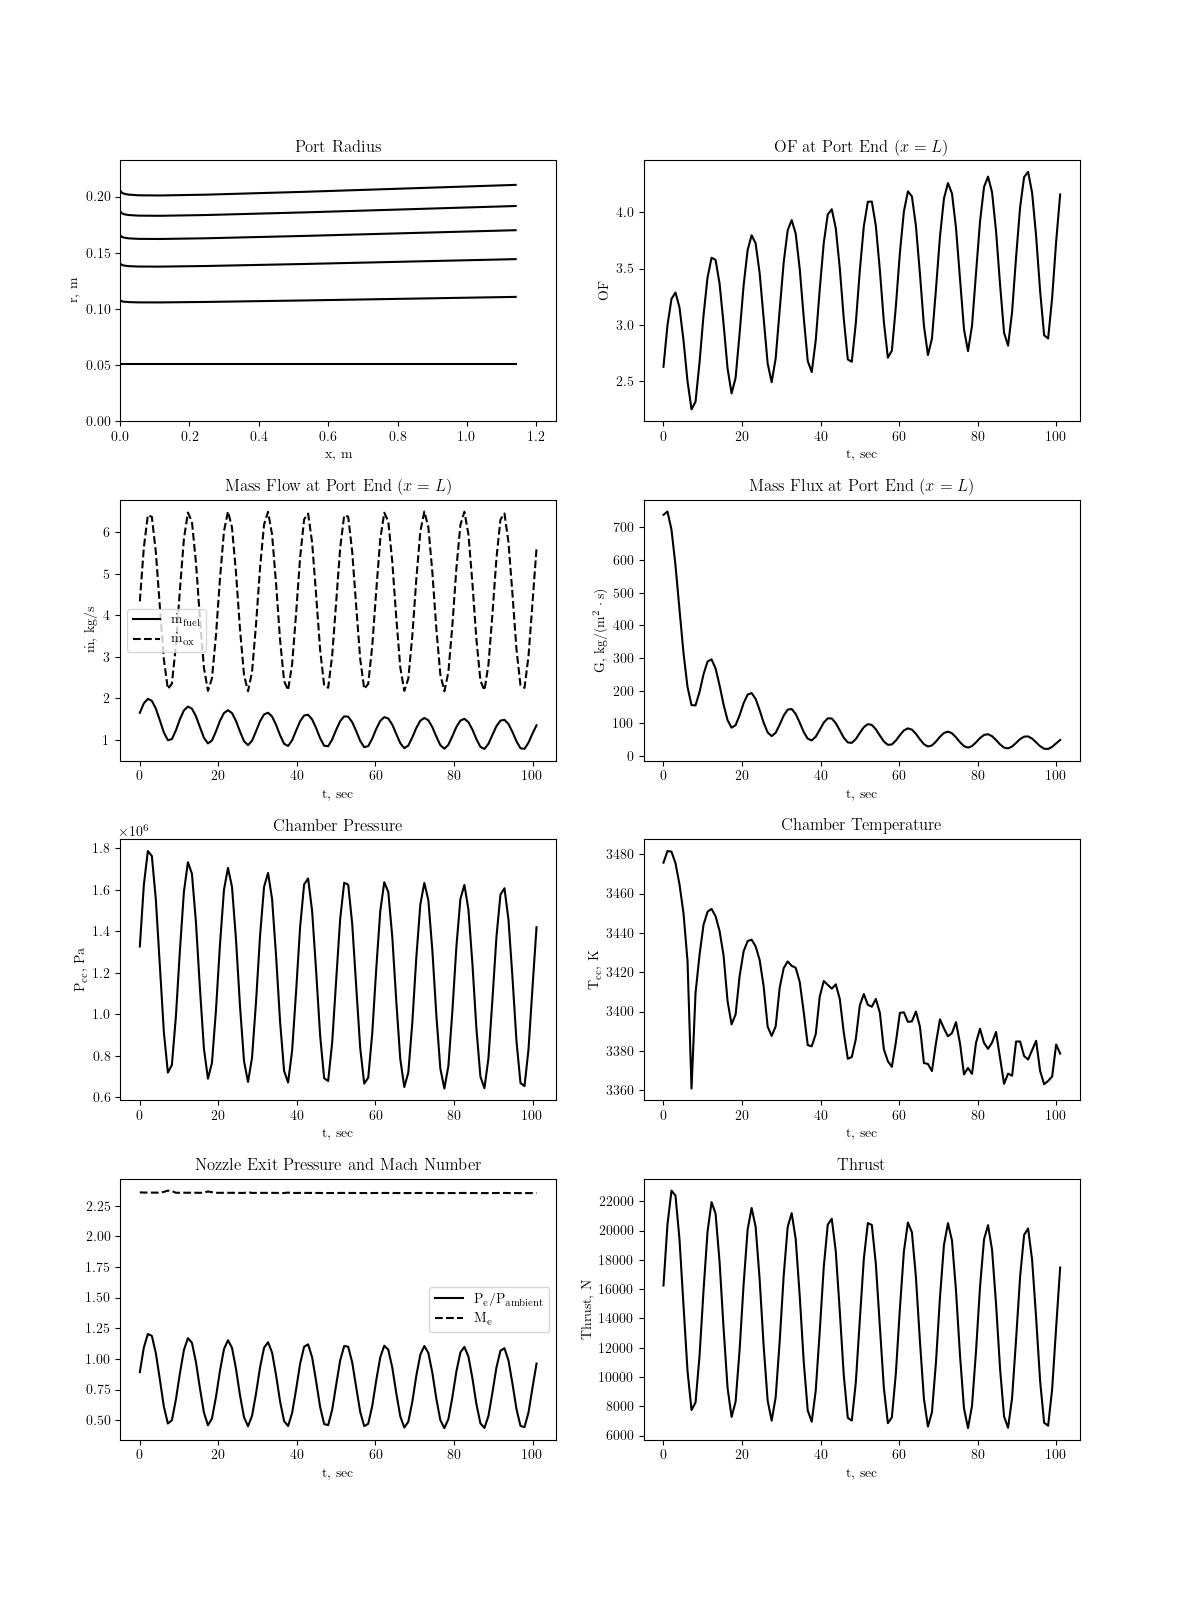

In [11]:
plt.close('all')
fig = plt.figure(figsize=(12,16), dpi= 100)
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
# Plot avg radius at various times
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    s = s + " s"
    return s
ax = fig.add_subplot(4,2,1)
CS = ax.contour(xgrid,rout,tgrid,np.linspace(0,tburn,6),colors='k')
ax.set_xlabel('x, m')
ax.set_ylabel('r, m')
ax.set_title('Port Radius')
# ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_ylim([0,1.1*rout.max()])
ax.set_xlim([0,1.1*x.max()])

# Plot OF at port end
ax = fig.add_subplot(4,2,2)
ax.plot(tout,ofout[-1,:],'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('OF')
ax.set_title('OF at Port End ($x = L$)')

# Plot mfuel at port end
ax = fig.add_subplot(4,2,3)
ax.plot(tout,mfout[-1,:],'k',label='$\mathrm{\dot m_{fuel}}$')
ax.plot(tout,moout[-1,:],'k--',label='$\mathrm{\dot m_{ox}}$')
ax.set_xlabel('t, sec')
ax.set_ylabel('$\mathrm{\dot m}$, kg/s')
ax.set_title('Mass Flow at Port End ($x = L$)')
ax.legend()

# Plot mass flux at port end
ax = fig.add_subplot(4,2,4)
ax.plot(tout,(mfout[-1,:]+moout[-1,:])/(np.pi*(rout[-1,:]**2)),'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('G, $\mathrm{kg/(m^2 \cdot s)}$')
ax.set_title('Mass Flux at Port End ($x = L$)')

# Plot chamber pressure
ax = fig.add_subplot(4,2,5)
ax.plot(tout,pccout,'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('$\mathrm{P_{cc}}$, Pa')
ax.set_title('Chamber Pressure')

# Plot chamber temp
ax = fig.add_subplot(4,2,6)
ax.plot(tout,tccout,'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('$\mathrm{T_{cc}}$, K')
ax.set_title('Chamber Temperature')

# Plot nozzle exit pressure ratio and mach number
ax = fig.add_subplot(4,2,7)
ax.plot(tout,peout/101325,'k',label='$\mathrm{P_{e}/P_{ambient}}$')
ax.plot(tout,meout,'k--',label='$\mathrm{M_e}$')
ax.legend()
ax.set_xlabel('t, sec')
ax.set_title('Nozzle Exit Pressure and Mach Number')

# Plot thrust
ax = fig.add_subplot(4,2,8)
ax.plot(tout,thrustout,'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('Thrust, N')
ax.set_title('Thrust')

# plt.savefig('ThrustControl',bbox_inches='tight',dpi=600)

Text(0.5, 1.0, 'Thrust')

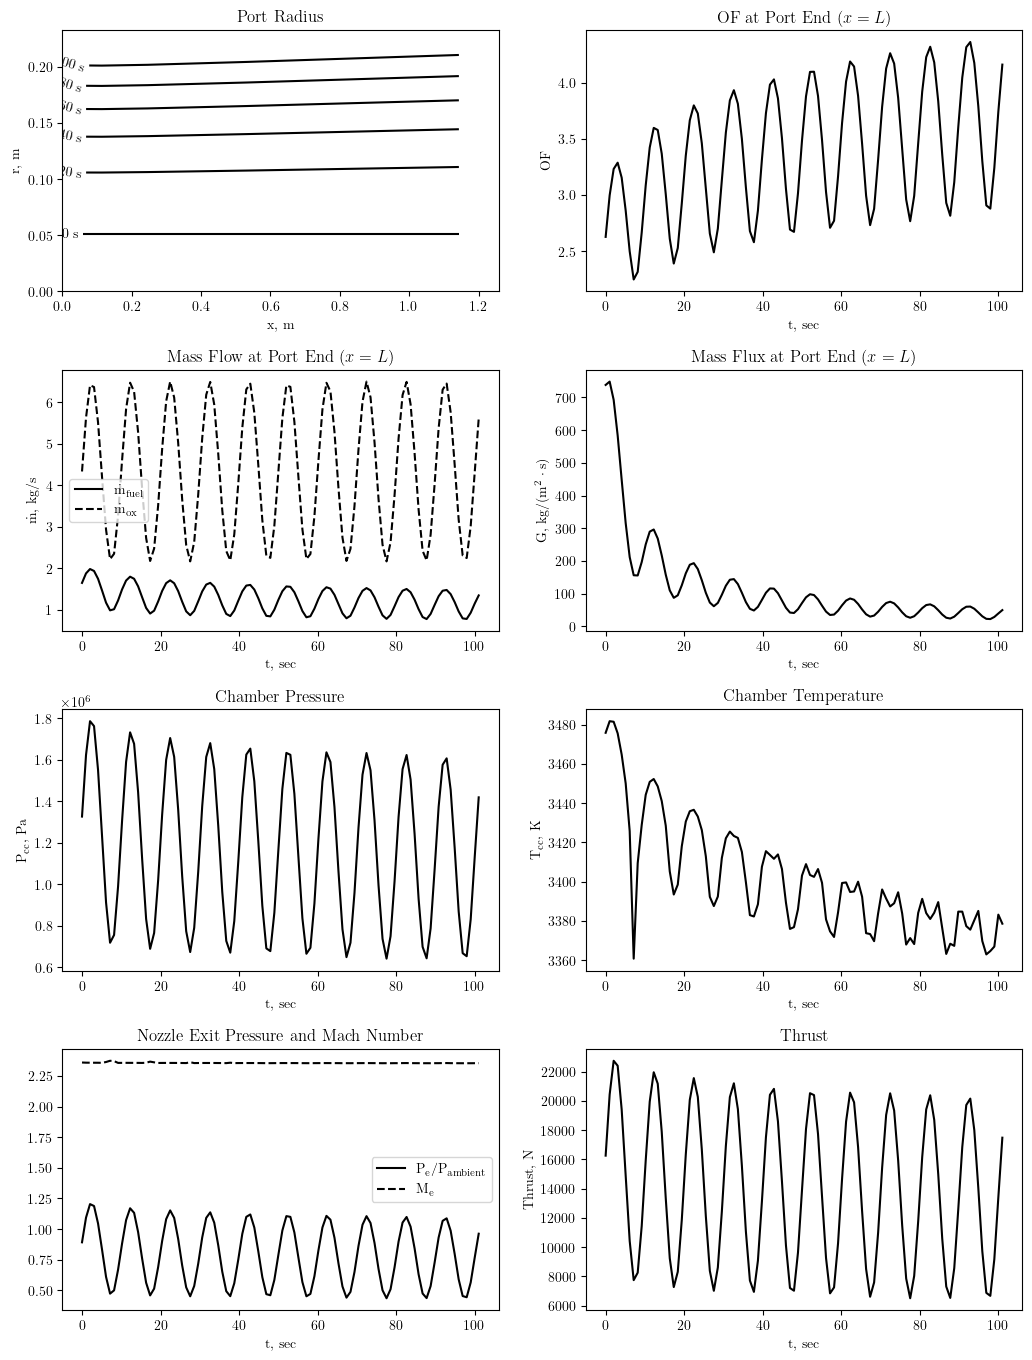

In [8]:
plt.close('all')
fig = plt.figure(figsize=(12,16), dpi= 100)
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
# Plot avg radius at various times
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    s = s + " s"
    return s
ax = fig.add_subplot(4,2,1)
CS = ax.contour(xgrid,rout,tgrid,np.linspace(0,tburn,6),colors='k')
ax.set_xlabel('x, m')
ax.set_ylabel('r, m')
ax.set_title('Port Radius')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_ylim([0,1.1*rout.max()])
ax.set_xlim([0,1.1*x.max()])

# Plot OF at port end
ax = fig.add_subplot(4,2,2)
ax.plot(tout,ofout[-1,:],'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('OF')
ax.set_title('OF at Port End ($x = L$)')

# Plot mfuel at port end
ax = fig.add_subplot(4,2,3)
ax.plot(tout,mfout[-1,:],'k',label='$\mathrm{\dot m_{fuel}}$')
ax.plot(tout,moout[-1,:],'k--',label='$\mathrm{\dot m_{ox}}$')
ax.set_xlabel('t, sec')
ax.set_ylabel('$\mathrm{\dot m}$, kg/s')
ax.set_title('Mass Flow at Port End ($x = L$)')
ax.legend()

# Plot mass flux at port end
ax = fig.add_subplot(4,2,4)
ax.plot(tout,(mfout[-1,:]+moout[-1,:])/(np.pi*(rout[-1,:]**2)),'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('G, $\mathrm{kg/(m^2 \cdot s)}$')
ax.set_title('Mass Flux at Port End ($x = L$)')

# Plot chamber pressure
ax = fig.add_subplot(4,2,5)
ax.plot(tout,pccout,'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('$\mathrm{P_{cc}}$, Pa')
ax.set_title('Chamber Pressure')

# Plot chamber temp
ax = fig.add_subplot(4,2,6)
ax.plot(tout,tccout,'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('$\mathrm{T_{cc}}$, K')
ax.set_title('Chamber Temperature')

# Plot nozzle exit pressure ratio and mach number
ax = fig.add_subplot(4,2,7)
ax.plot(tout,peout/101325,'k',label='$\mathrm{P_{e}/P_{ambient}}$')
ax.plot(tout,meout,'k--',label='$\mathrm{M_e}$')
ax.legend()
ax.set_xlabel('t, sec')
ax.set_title('Nozzle Exit Pressure and Mach Number')

# Plot thrust
ax = fig.add_subplot(4,2,8)
ax.plot(tout,thrustout,'k')
ax.set_xlabel('t, sec')
ax.set_ylabel('Thrust, N')
ax.set_title('Thrust')

# plt.savefig('ThrustControl',bbox_inches='tight',dpi=600)